In [88]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt
import matplotlib.pyplot 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns


<h3> Download the data, if not already on disk and load it as numpy arrays </h3>

In [4]:
lfw_people = fetch_lfw_people(min_faces_per_person=50, resize=0.4)

In [5]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

Number of samples: 1560
Height: 50
Width: 37


In [93]:
X = lfw_people.data
n_features = X.shape[1]

In [7]:
# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

In [8]:
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1560
n_features: 1850
n_classes: 12


<h3> Train/Test Split </h3>

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

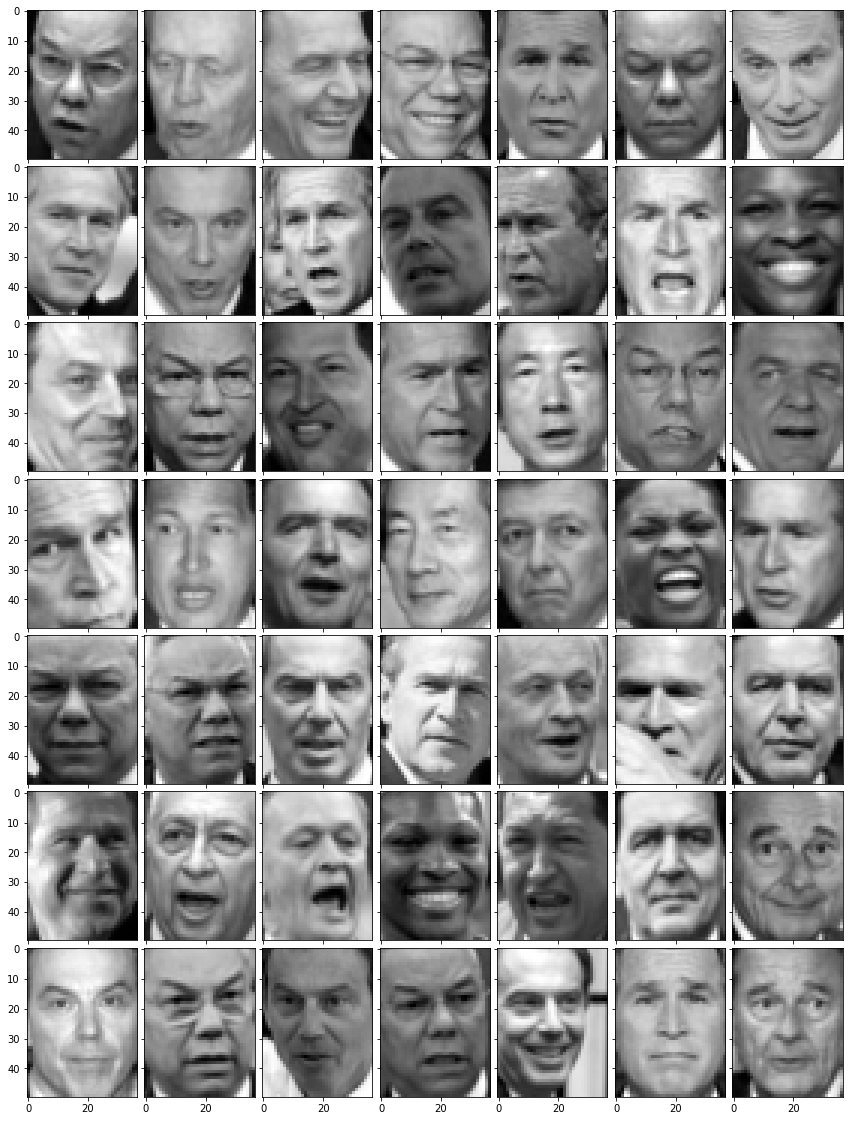

In [87]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(1, (20., 20.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(7, 7),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for i in range(49):
    grid[i].imshow(X_test[i].reshape((h,w)),cmap=plt.cm.gray)  # The AxesGrid object work as a list of axes.

plt.show()

<h3> Perform PCA </h3>

In [10]:
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"% (n_components, X_train.shape[0]))
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
eigenfaces = pca.components_.reshape((n_components, h, w))

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Extracting the top 150 eigenfaces from 1170 faces
done in 24.727s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.146s


In [11]:
###############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set


c:\users\clyde\anaconda3\envs\dask-scipy\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


done in 105.058s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


Predicting people's names on the test set
done in 0.202s
                   precision    recall  f1-score   support

     Ariel Sharon       0.68      0.76      0.72        17
     Colin Powell       0.76      0.87      0.81        62
  Donald Rumsfeld       0.83      0.69      0.75        29
    George W Bush       0.79      0.84      0.82       124
Gerhard Schroeder       0.87      0.75      0.81        36
      Hugo Chavez       0.68      0.93      0.79        14
   Jacques Chirac       0.75      0.60      0.67        20
    Jean Chretien       0.81      0.87      0.84        15
    John Ashcroft       0.71      0.56      0.63         9
Junichiro Koizumi       0.85      0.73      0.79        15
  Serena Williams       1.00      0.80      0.89        15
       Tony Blair       0.74      0.68      0.71        34

         accuracy                           0.79       390
        macro avg       0.79      0.76      0.77       390
     weighted avg       0.79      0.79      0.79       3

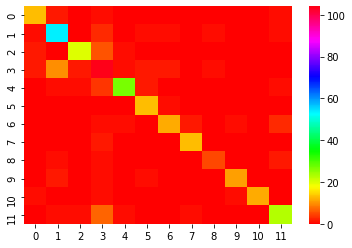

In [95]:
print("Predicting people's names on the test set")
y_pred = clf.predict(X_test_pca)

print(classification_report(y_test, y_pred, target_names=target_names))
corr_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(corr_mat, cmap='hsv', annot_kws={'size':20})

In [ ]:
###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

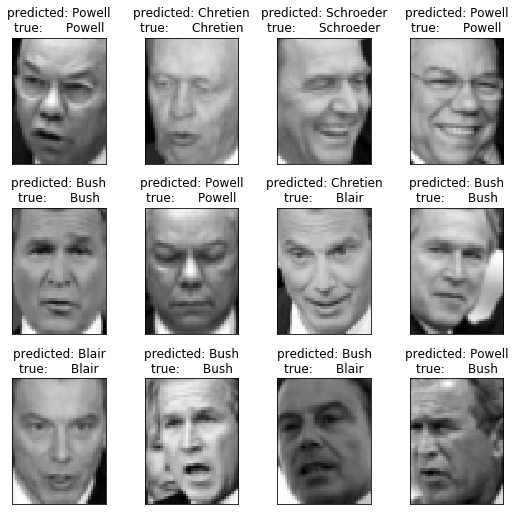

In [14]:
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

<h3> Quantitative evaluation of the model quality on the test set </h3>

In [ ]:
X, y = X_train, y_train
rf_clf = OneVsRestClassifier(RandomForestClassifier(min_samples_leaf=5),n_jobs=-1)
rf_clf.fit(X, y)
pred_rf = rf_clf.predict_proba(X_test)

                   precision    recall  f1-score   support

     Ariel Sharon       0.56      0.29      0.38        17
     Colin Powell       0.63      0.63      0.63        62
  Donald Rumsfeld       0.29      0.14      0.19        29
    George W Bush       0.52      0.90      0.66       124
Gerhard Schroeder       0.57      0.22      0.32        36
      Hugo Chavez       0.41      0.50      0.45        14
   Jacques Chirac       0.00      0.00      0.00        20
    Jean Chretien       0.60      0.20      0.30        15
    John Ashcroft       0.50      0.11      0.18         9
Junichiro Koizumi       0.67      0.27      0.38        15
  Serena Williams       0.76      0.87      0.81        15
       Tony Blair       0.43      0.38      0.41        34

         accuracy                           0.54       390
        macro avg       0.50      0.38      0.39       390
     weighted avg       0.51      0.54      0.48       390

[[  5   5   1   5   0   1   0   0   0   0   0   0]
 [

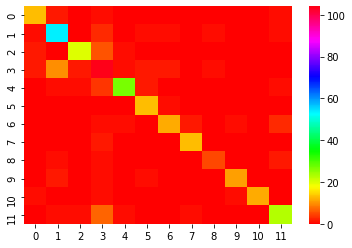

In [90]:
pred_rf1 = np.argmax(pred_rf, axis=1, out=None)
print(classification_report(y_test, pred_rf1, target_names=target_names))
print(confusion_matrix(y_test, pred_rf1, labels=range(n_classes)))
corr_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(corr_mat, cmap='hsv', annot_kws={'size':20})

In [49]:
X, y = X_train,y_train
logit_clf = OneVsRestClassifier(LogisticRegression(solver='lbfgs'),n_jobs=4)
logit_clf.fit(X, y)
pred_logit =logit_clf.predict_proba(X_test)

In [100]:
pred_logit1 = np.argmax(pred_logit, axis=1, out=None)
print(classification_report(y_test, pred_logit1, target_names=target_names))
print(confusion_matrix(y_test, pred_logit1, labels=range(n_classes)))

                   precision    recall  f1-score   support

     Ariel Sharon       0.92      0.71      0.80        17
     Colin Powell       0.78      0.85      0.82        62
  Donald Rumsfeld       0.69      0.62      0.65        29
    George W Bush       0.82      0.81      0.81       124
Gerhard Schroeder       0.76      0.72      0.74        36
      Hugo Chavez       0.55      0.79      0.65        14
   Jacques Chirac       0.63      0.60      0.62        20
    Jean Chretien       0.73      0.73      0.73        15
    John Ashcroft       0.38      0.33      0.35         9
Junichiro Koizumi       0.75      0.80      0.77        15
  Serena Williams       0.79      0.73      0.76        15
       Tony Blair       0.66      0.68      0.67        34

         accuracy                           0.75       390
        macro avg       0.71      0.70      0.70       390
     weighted avg       0.75      0.75      0.75       390

[[ 12   2   0   2   1   0   0   0   0   0   0   0]
 [

In [97]:
pred_logit1 = np.argmax(pred_logit, axis=1, out=None)

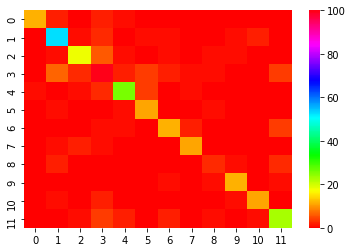

In [99]:
corr_mat = confusion_matrix(y_test, pred_logit1)
sns.heatmap(corr_mat, cmap='hsv', annot_kws={'size':20})
plt.show()